Epoch 1/50
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.9119 - loss: 0.2765 - val_accuracy: 0.9084 - val_loss: 0.3082
Epoch 2/50
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.9170 - loss: 0.2143 - val_accuracy: 0.9093 - val_loss: 0.3294
Epoch 3/50
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9193 - loss: 0.2041 - val_accuracy: 0.9091 - val_loss: 0.3432
Epoch 4/50
11734/11734 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.9207 - loss: 0.1956 - val_accuracy: 0.9094 - val_loss: 0.3535
6663/6663 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9127 - loss: 0.3039
Test Accuracy: 0.9143
6663/6663 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


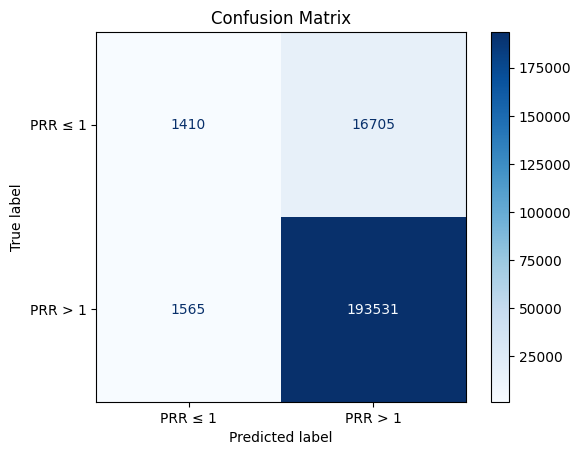

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load data
df = pd.read_csv("TWOSIDES.csv")  # Replace with your file path

# Label encoding
label_encoders = {}
for col in ['drug_1_rxnorn_id', 'drug_2_rxnorm_id', 'condition_meddra_id']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Target label
y = (df['PRR'] > 1.0).astype(int)
df = df.drop(columns=['PRR'])  # Remove target leakage

# REMOVE all numeric features
X = df[['drug_1_rxnorn_id', 'drug_2_rxnorm_id', 'condition_meddra_id']]

# Custom drug-based train-test split (simulate unseen drugs)
unique_drugs = X['drug_1_rxnorn_id'].unique()
np.random.shuffle(unique_drugs)
split_idx = int(len(unique_drugs) * 0.8)
train_drugs = unique_drugs[:split_idx]
test_drugs = unique_drugs[split_idx:]

train_idx = X['drug_1_rxnorn_id'].isin(train_drugs)
test_idx = X['drug_1_rxnorn_id'].isin(test_drugs)

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Vocab sizes
vocab_size = {
    'drug_1': X['drug_1_rxnorn_id'].nunique(),
    'drug_2': X['drug_2_rxnorm_id'].nunique(),
    'condition': X['condition_meddra_id'].nunique()
}

# Inputs
input_drug1 = Input(shape=(1,), name='drug_1')
input_drug2 = Input(shape=(1,), name='drug_2')
input_condition = Input(shape=(1,), name='condition')

# Small embeddings
embed_drug1 = Embedding(input_dim=vocab_size['drug_1'] + 1, output_dim=4)(input_drug1)
embed_drug2 = Embedding(input_dim=vocab_size['drug_2'] + 1, output_dim=4)(input_drug2)
embed_condition = Embedding(input_dim=vocab_size['condition'] + 1, output_dim=4)(input_condition)

# Flatten
flat_drug1 = Flatten()(embed_drug1)
flat_drug2 = Flatten()(embed_drug2)
flat_condition = Flatten()(embed_condition)

# Concatenate
x = Concatenate()([flat_drug1, flat_drug2, flat_condition])

# Simple dense layer
x = Dense(16, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

# Build model
model = Model(inputs=[input_drug1, input_drug2, input_condition], outputs=output)
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001, restore_best_weights=True)

# Train
history = model.fit(
    x={
        'drug_1': X_train['drug_1_rxnorn_id'],
        'drug_2': X_train['drug_2_rxnorm_id'],
        'condition': X_train['condition_meddra_id']
    },
    y=y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
loss, acc = model.evaluate(
    x={
        'drug_1': X_test['drug_1_rxnorn_id'],
        'drug_2': X_test['drug_2_rxnorm_id'],
        'condition': X_test['condition_meddra_id']
    },
    y=y_test
)

print(f"Test Accuracy: {acc:.4f}")

# Confusion Matrix
y_pred_prob = model.predict({
    'drug_1': X_test['drug_1_rxnorn_id'],
    'drug_2': X_test['drug_2_rxnorm_id'],
    'condition': X_test['condition_meddra_id']
})

y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["PRR ≤ 1", "PRR > 1"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
